In [23]:
import datetime as dt
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from preprocessing_scripts.labels import labels

In [24]:
conn = sqlite3.connect('data/FPA_FOD_20170508.sqlite')

# Data Pre-Processing

## Feature Selection from the dataset

In [25]:
df = pd.read_sql_query("SELECT STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,FIRE_SIZE_CLASS FROM 'Fires'", conn)
#df = pd.read_csv('data/train.csv',usecols = ['STAT_CAUSE_DESCR','LATITUDE','LONGITUDE','DISCOVERY_DATE','FIRE_SIZE','STATE'])

In [26]:
print(df.head())

  STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  FIRE_SIZE  \
0    Miscellaneous  40.036944 -121.005833    CA       2453403.5       0.10   
1        Lightning  38.933056 -120.404444    CA       2453137.5       0.25   
2   Debris Burning  38.984167 -120.735556    CA       2453156.5       0.10   
3        Lightning  38.559167 -119.913333    CA       2453184.5       0.10   
4        Lightning  38.559167 -119.933056    CA       2453184.5       0.10   

  FIRE_SIZE_CLASS  
0               A  
1               A  
2               A  
3               A  
4               A  


## Convert date from Julian to Gregorian calendar format

In [27]:
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['DAY_OF_WEEK'] = pd.to_datetime(df['DISCOVERY_DATE']).dt.weekday_name
df['MONTH'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).month

In [28]:
print(df.head())

  STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE DISCOVERY_DATE  FIRE_SIZE  \
0    Miscellaneous  40.036944 -121.005833    CA     2005-02-02       0.10   
1        Lightning  38.933056 -120.404444    CA     2004-05-12       0.25   
2   Debris Burning  38.984167 -120.735556    CA     2004-05-31       0.10   
3        Lightning  38.559167 -119.913333    CA     2004-06-28       0.10   
4        Lightning  38.559167 -119.933056    CA     2004-06-28       0.10   

  FIRE_SIZE_CLASS DAY_OF_WEEK  MONTH  
0               A   Wednesday      2  
1               A   Wednesday      5  
2               A      Monday      5  
3               A      Monday      6  
4               A      Monday      6  


# Charts

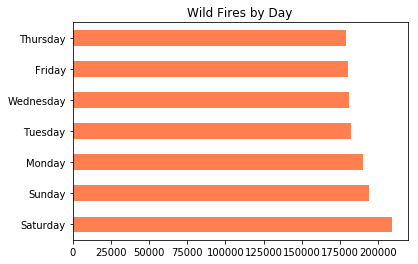

In [7]:
df['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral', title ="Wild Fires by Day")
plt.show()

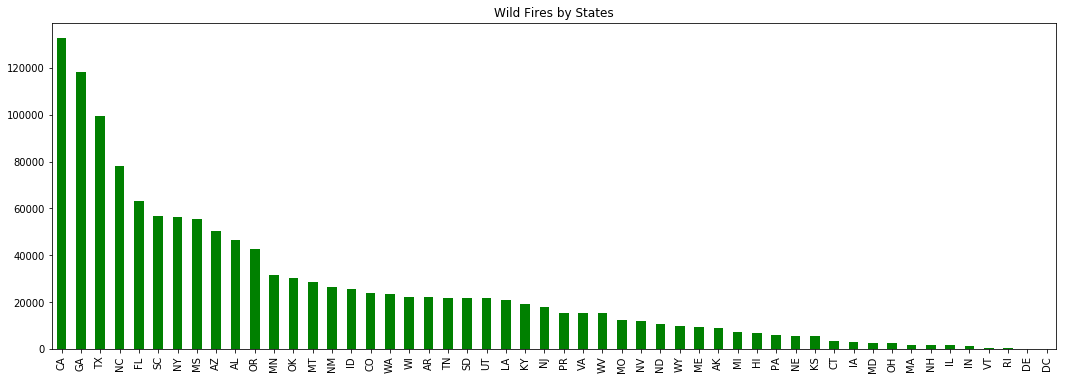

In [8]:
df['STATE'].value_counts().plot(kind='bar',color='green', figsize=(18, 6), title ="Wild Fires by States")
plt.show()

In [9]:
cause_df = df.groupby(['STAT_CAUSE_DESCR']).size().reset_index(name='COUNT')

In [10]:
print(cause_df)

     STAT_CAUSE_DESCR   COUNT
0               Arson  196646
1            Campfire   53313
2            Children   43120
3      Debris Burning  300340
4       Equipment Use  103407
5           Fireworks    7966
6           Lightning  195073
7       Miscellaneous  226641
8   Missing/Undefined  116740
9           Powerline   10134
10           Railroad   23531
11            Smoking   36770
12          Structure    2645


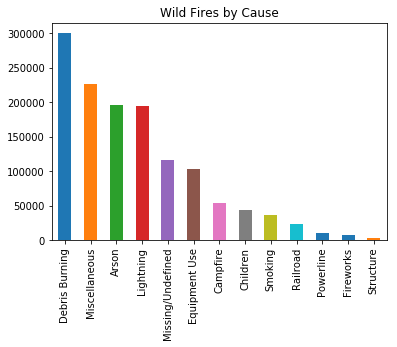

In [11]:
df['STAT_CAUSE_DESCR'].value_counts().plot(kind='bar', title ="Wild Fires by Cause")

# Support Vector Machine (SVM)

In [29]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# df['STAT_CAUSE_DESCR'] = le.fit_transform(df['STAT_CAUSE_DESCR'])
df['STATE'] = le.fit_transform(df['STATE'])
df['DAY_OF_WEEK'] = le.fit_transform(df['DAY_OF_WEEK'])
df['MONTH'] = le.fit_transform(df['MONTH'])
df = labels.createLabel(df)
df['STAT_CAUSE_DESCR'] =df['STAT_CAUSE_DESCR'].astype(int)
print(df.head())

/Users/sheena/Jupyter/CMPE256/Project/preprocessing_scripts/labels.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  labels['STAT_CAUSE_DESCR'][labels.STAT_CAUSE_DESCR == 'Arson']=0
/Users/sheena/Jupyter/CMPE256/Project/preprocessing_scripts/labels.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  labels['STAT_CAUSE_DESCR'][labels.STAT_CAUSE_DESCR == 'Lightning']=1
/Users/sheena/Jupyter/CMPE256/Project/preprocessing_scripts/labels.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 

   STAT_CAUSE_DESCR   LATITUDE   LONGITUDE  STATE DISCOVERY_DATE  FIRE_SIZE  \
0                 4  40.036944 -121.005833      4     2005-02-02       0.10   
1                 1  38.933056 -120.404444      4     2004-05-12       0.25   
2                 2  38.984167 -120.735556      4     2004-05-31       0.10   
3                 1  38.559167 -119.913333      4     2004-06-28       0.10   
4                 1  38.559167 -119.933056      4     2004-06-28       0.10   

  FIRE_SIZE_CLASS  DAY_OF_WEEK  MONTH  
0               A            6      1  
1               A            6      4  
2               A            1      4  
3               A            1      5  
4               A            1      5  


/Users/sheena/Jupyter/CMPE256/Project/preprocessing_scripts/labels.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  labels['STAT_CAUSE_DESCR'][labels.STAT_CAUSE_DESCR == 'Missing/Undefined']=4


In [30]:
from sklearn import svm
from sklearn.model_selection import train_test_split 

df = df.head(50000)
X = df[['DAY_OF_WEEK','MONTH','STATE', 'LATITUDE','LONGITUDE','FIRE_SIZE']]
y = df['STAT_CAUSE_DESCR']



X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20)
model = svm.SVC(gamma='scale')

model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [31]:
y_pred = model.predict(X_test)
y_pred 

array([1, 1, 0, ..., 1, 1, 1])

In [43]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print("Classification Report")
print(classification_report(y_test,y_pred))  
print("Score for SVM is:",model.score(X_train, y_train))
print("Accuracy score:",accuracy_score(y_test,y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.96      0.80      6222
           1       0.50      0.25      0.33      2672
           2       0.00      0.00      0.00       696
           3       0.00      0.00      0.00       157
           4       0.00      0.00      0.00        97
           5       0.00      0.00      0.00        84
           6       0.00      0.00      0.00        72

   micro avg       0.66      0.66      0.66     10000
   macro avg       0.17      0.17      0.16     10000
weighted avg       0.56      0.66      0.59     10000



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Score for SVM is: 0.6716
Accuracy score: 0.6631


# Confusion Matrix

In [33]:
from pandas_ml import ConfusionMatrix

confusion_matrix = ConfusionMatrix(y_test, y_pred)
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
Predicted    0     1  2   3   4  __all__
Actual                                  
0           23   196  0   0   4      223
1          138   816  0   6   8      968
2           14   101  0   1   0      116
3           49   364  0   3   5      421
4           26   230  0   0   2      258
__all__    250  1707  0  10  19     1986


/anaconda3/lib/python3.7/site-packages/pandas_ml/confusion_matrix/abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing


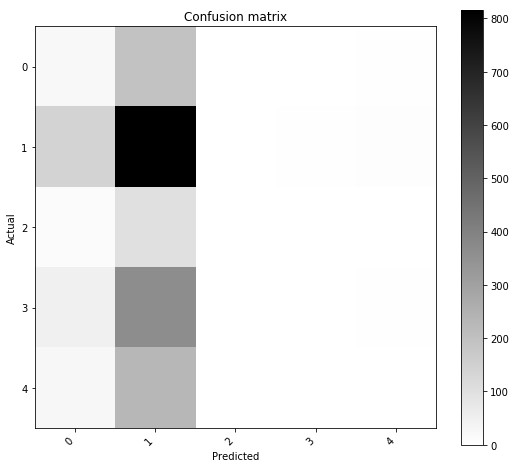

In [34]:
confusion_matrix.plot()

# Corelation Matrix

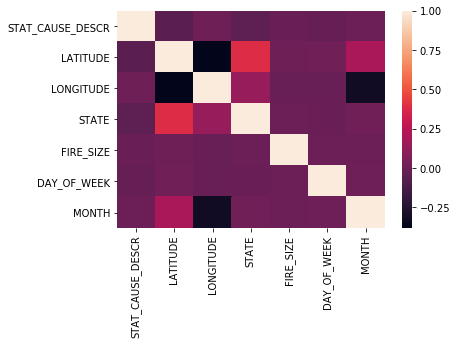

In [35]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# Decision Tree Classifier

In [36]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()


clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Classification Report")
print(classification_report(y_test,y_pred))  

print("Accuracy score:",accuracy_score(y_test,y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.47      0.48      0.48       782
           1       0.81      0.80      0.81      5494
           2       0.27      0.27      0.27       483
           3       0.42      0.41      0.42      1998
           4       0.28      0.28      0.28      1243

   micro avg       0.61      0.61      0.61     10000
   macro avg       0.45      0.45      0.45     10000
weighted avg       0.61      0.61      0.61     10000

Accuracy score: 0.6109


# Bagging Classifier

In [37]:
from sklearn.ensemble import BaggingClassifier


clf_ws = BaggingClassifier(n_estimators=5, warm_start=True,random_state=3141)
clf_ws.fit(X_train, y_train)
y1 = clf_ws.predict(X_test)

print("Classification Report")
print(classification_report(y_test,y1))  

print("Accuracy score:",accuracy_score(y_test,y1))

clf = BaggingClassifier(n_estimators=10, warm_start=False,random_state=3141)
clf.fit(X_train, y_train)
y2 = clf.predict(X_test)

print("Classification Report")
print(classification_report(y_test,y2))  

print("Accuracy score:",accuracy_score(y_test,y2))

clf = BaggingClassifier(n_estimators=20, warm_start=False,random_state=3141)
clf.fit(X_train, y_train)
y3 = clf.predict(X_test)

print("Classification Report")
print(classification_report(y_test,y3))  

print("Accuracy score:",accuracy_score(y_test,y3))

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.60      0.55       782
           1       0.80      0.88      0.84      5494
           2       0.37      0.29      0.33       483
           3       0.50      0.43      0.46      1998
           4       0.36      0.24      0.29      1243

   micro avg       0.66      0.66      0.66     10000
   macro avg       0.50      0.49      0.49     10000
weighted avg       0.64      0.66      0.65     10000

Accuracy score: 0.6625
Classification Report
              precision    recall  f1-score   support

           0       0.55      0.62      0.58       782
           1       0.80      0.90      0.85      5494
           2       0.41      0.30      0.34       483
           3       0.51      0.44      0.48      1998
           4       0.38      0.27      0.32      1243

   micro avg       0.68      0.68      0.68     10000
   macro avg       0.53      0.50      0.51     10000
weighted a

# Predict fire severity (FIRE_SIZE_CLASS)

In [40]:
le = preprocessing.LabelEncoder()
df['STAT_CAUSE_DESCR'] = le.fit_transform(df['STAT_CAUSE_DESCR'])
df['DAY_OF_WEEK'] = le.fit_transform(df['DAY_OF_WEEK'])
df['MONTH'] = le.fit_transform(df['MONTH'])
df['FIRE_SIZE_CLASS'] = le.fit_transform(df['FIRE_SIZE_CLASS'])
df['STATE'] = le.fit_transform(df['STATE'])
X = df[['DAY_OF_WEEK','MONTH','STATE', 'LATITUDE','LONGITUDE','STAT_CAUSE_DESCR']]
y = df['FIRE_SIZE_CLASS']


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20)
model = svm.SVC(gamma='scale')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred 


array([0, 0, 0, ..., 0, 1, 0])

In [41]:
print("Classification Report")
print(classification_report(y_test,y_pred))  
print("Score for SVM is:",model.score(X_train, y_train))
print("Accuracy score:",accuracy_score(y_test,y_pred))

y_test

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.96      0.80      6222
           1       0.50      0.25      0.33      2672
           2       0.00      0.00      0.00       696
           3       0.00      0.00      0.00       157
           4       0.00      0.00      0.00        97
           5       0.00      0.00      0.00        84
           6       0.00      0.00      0.00        72

   micro avg       0.66      0.66      0.66     10000
   macro avg       0.17      0.17      0.16     10000
weighted avg       0.56      0.66      0.59     10000



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Score for SVM is: 0.6716
Accuracy score: 0.6631


6080     0
41268    0
48486    1
40236    0
36664    1
47782    0
4333     6
48466    0
40301    0
49375    0
36522    0
25366    1
28444    6
32120    1
22009    0
35068    0
22898    0
16330    1
29928    1
95       0
28596    0
42091    1
28498    0
11684    0
49981    0
31049    1
26413    0
34957    0
45490    0
11288    0
        ..
14886    0
12378    0
40662    0
34052    1
13842    3
38904    3
28918    0
45796    0
16763    0
41712    0
26553    0
46247    0
2764     1
7161     2
10003    0
6038     0
148      1
6593     2
29582    0
42718    0
6901     0
40390    0
30177    1
35711    1
31267    0
31306    2
28636    1
3327     0
18467    1
28156    0
Name: FIRE_SIZE_CLASS, Length: 10000, dtype: int64

In [44]:
confusion_matrix = ConfusionMatrix(y_test, y_pred)
print("F1-score: %f"%(f1_score(y_test,y_pred,average='macro')))
print("Accuracy: %f"%(accuracy_score(y_test,y_pred)))
print("Confusion matrix:\n%s" % confusion_matrix)

F1-score: 0.162277
Accuracy: 0.663100
Confusion matrix:
Predicted     0    1  2  3  4  5  6  __all__
Actual                                      
0          1064  151  0  0  0  0  0     1215
1           488   87  0  0  0  0  0      575
2           156   24  0  0  0  0  0      180
3            25    6  0  0  0  0  0       31
4            18    4  0  0  0  0  0       22
5            15    1  0  0  0  0  0       16
6            10    2  0  0  0  0  0       12
__all__    1776  275  0  0  0  0  0     2051


/anaconda3/lib/python3.7/site-packages/pandas_ml/confusion_matrix/abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
